## Simplified Self attention mechanism

In [ ]:
import torch
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your (x^1)
    [0.55, 0.87, 0.66], # journey (x^2)
    [0.57, 0.85, 0.64], # starts (x^3)
    [0.22, 0.58, 0.33], # with (x^4)
    [0.77, 0.25, 0.10], # one (x^5)
    [0.05, 0.80, 0.55]] # step (x^6)
)

In [ ]:
query = inputs[1]
attention_scores2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attention_scores2[i] = torch.dot(x_i, query)

print(attention_scores2)

In [ ]:
attention_scores2_normalized = attention_scores2 / attention_scores2.sum()
print(attention_scores2_normalized)

In [ ]:
attention_scores2_softmax_normalized = torch.softmax(attention_scores2, dim=0)
print(attention_scores2_softmax_normalized)

In [ ]:
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vec_2 += attention_scores2_softmax_normalized[i] * x_i

print(context_vec_2)

In [ ]:
# Self Attention over complete set of words
attention_scores = torch.empty(6, 6)
for i, xi in enumerate(inputs):
    for j, xj in enumerate(inputs):
        attention_scores[i, j] = torch.dot(xi, xj)

print(attention_scores)

In [ ]:
attention_scores = inputs @ inputs.T # Similar to the previous piece of code.

In [ ]:
attention_weights = torch.softmax(attention_scores, dim=-1)

In [ ]:
context_vectors = attention_weights @ inputs

In [ ]:
print(context_vectors)

## Self-Attention with trainable weights

In [ ]:
import torch
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your (x^1)
    [0.55, 0.87, 0.66], # journey (x^2)
    [0.57, 0.85, 0.64], # starts (x^3)
    [0.22, 0.58, 0.33], # with (x^4)
    [0.77, 0.25, 0.10], # one (x^5)
    [0.05, 0.80, 0.55]] # step (x^6)
)

In [ ]:
x2 = inputs[1]
d_in = inputs.shape[1] # 3
d_out = 2

In [ ]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out, requires_grad=False))

In [ ]:
query2 = x2 @ W_query
key2 = x2 @ W_key
value2 = x2 @ W_value

In [ ]:
print(query2)

In [ ]:
attention_score22 = query2.dot(key2)

In [ ]:
print(attention_score22)

In [ ]:
# Let's find attention score of query2 with all the other tokens in the sequence
keys = inputs @ W_key
attention_score2 = query2 @ keys.T
print(attention_score2)

In [ ]:
# We will now take perform a scaled-normalization by dividing the scores by sqrt(embedding_dimension of key)
'''
    The reason behind the scaling of the attention scores is to improve
    the training performance by avoiding smaller gradients

    More the number of dimensions, larger the dot product so when we apply
    softmax function to the dot product the softmax behaves like a step function
    i.e it stays flat which results in gradients near to zero, now with small gradients
    the training process will slow down drastically
'''
# This is the reason why its known as scaled-dot product attention.
d_k = keys.shape[1]
attention_weight2 = torch.softmax(attention_score2 / d_k ** 0.5, dim=0)

In [ ]:
attention_weight2

In [ ]:
values = inputs @ W_value
context_vec2 = attention_weight2 @ values
print(context_vec2)

In [ ]:
import torch.nn as nn
class SelfAttentionV1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=False)
        self.W_key = nn.Linear(d_in, d_out, bias=False)
        self.W_value = nn.Linear(d_in, d_out, bias=False)

    def forward(self, x):
        querys = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        attention_scores = querys @ keys.T
        attention_weight = torch.softmax(attention_scores / self.d_out ** 0.5, dim = -1)
        context_vectors = attention_weight @ values
        return context_vectors

In [ ]:
torch.manual_seed(789)
sa_v1 = SelfAttentionV1(d_in, d_out)
sa_v1(inputs)

## Casual Attention Mechanism
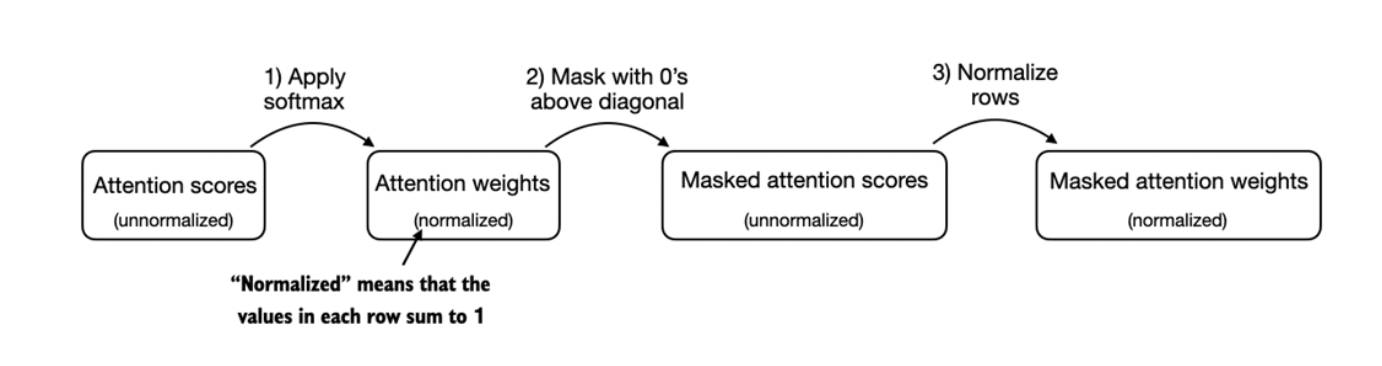

In [ ]:
queries = sa_v1.W_query(inputs)
keys = sa_v1.W_key(inputs)
values = sa_v1.W_value(inputs)

In [ ]:
attention_scores = queries @ keys.T
attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim = -1)
print(attention_weights)

In [ ]:
# 3rd Step to mask the attention_weights
context_length = attention_weights.shape[0]
simple_mask = torch.tril(torch.ones(context_length, context_length)) # Creates a masked lower triangular matrix
print(simple_mask, end="\n\n")

masked = attention_weights * simple_mask
print(masked)

In [ ]:
# 4th Step to normalized the masked attention_weights
row_sums = masked.sum(dim=1, keepdim=True)
masked_normalized = masked / row_sums
print(masked_normalized)

In [ ]:
'''
    While technically we can be done here, but for smoother training purpose
    we can use softmax function which ensure proper gradient flow,
    instead of zero we can have -inf which softmax will convert to 0
    there by normalizing as it is.
'''

mask = torch.triu(torch.ones(context_length, context_length), diagonal = 1) # Upper triangular matrix
masked_attention_scores = attention_weights.masked_fill(mask.bool(), -torch.inf)

print(masked_attention_scores)

In [ ]:
masked_attention_weights = torch.softmax(masked_attention_scores / d_out ** 0.5, dim = -1)
print(masked_attention_weights)

In [ ]:
# Calculating the context vectors using the new `masked_attention_weights`
context_vectors = masked_attention_weights @ values
print(context_vectors)

In [ ]:
# We can add a dropout layer to avoid overfitting, when applying dropout other factors or weights
# are scaled by that fraction to maintaing consistency in the results produced and learning that happens.
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
print(dropout(attention_weights))

In [ ]:
# Combining casual attention into a single compact class
import torch.nn as nn
class CasualAttentionV1(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias = False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
        # Use a register buffer to avoid training of the mask tensor.

    def forward(self, x):
        batch_size, no_of_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attention_scores = queries @ keys.transpose(1, 2)
        attention_scores.masked_fill(self.mask.bool()[:no_of_tokens][:no_of_tokens], -torch.inf)
        attention_weights = torch.softmax(attention_scores / self.d_out ** 0.5, dim = -1)
        attention_weights = self.dropout(attention_weights)

        context_vectors = attention_weights @ values
        return context_vectors

In [ ]:
torch.manual_seed(123)

# Let's consider a batch of inputs as we are going to fetch data from dataloader
batch = torch.stack((inputs, inputs), dim = 0)
print(batch.shape)

context_length = batch.shape[1]
ca = CasualAttentionV1(d_in, d_out, context_length, 0.0)
context_vectors = ca(batch)
print("context_vectors.shape -> ", context_vectors.shape)